In [1]:
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt

In [2]:
tlm = hp.read_alm("/Users/omard/Downloads/SCRATCHFOLDER/n32/S4WebskyWebskyBorn/cmbs/sim_0000_tlm.fits")

In [3]:
lmax = hp.Alm.getlmax(tlm.size)

In [4]:
nside = 2048

In [5]:
tmap = hp.alm2map(tlm, nside=nside)

In [154]:
clsoriginal = hp.alm2cl(tlm)

In [7]:
nlev_t = 1.

In [49]:
fconv = 180*60/np.pi
fconv = fconv**2.
pixarea = hp.nside2pixarea(nside)
pixarea *= fconv
invtotalnoise = np.array([np.nan_to_num(pixarea/nlev_t**2.)])
invtotalnoise = np.ones_like(tmap)*np.nan_to_num(pixarea/nlev_t**2.)


#invtotalnoise = hp.nside2pixarea(nside, degrees=True) * 60 ** 2 / nlev_t ** 2

invtotalnoise

array([2.95064172, 2.95064172, 2.95064172, ..., 2.95064172, 2.95064172,
       2.95064172])

In [50]:
invtotalnoise_alm = hp.map2alm(invtotalnoise, lmax = lmax)

In [34]:
neff = 10800. / np.sqrt(np.sum(invtotalnoise) / (4.0 * np.pi)) / np.pi

In [35]:
npix = len(tmap)
np.sqrt(4. * np.pi / npix / np.sum(invtotalnoise) * len(np.where(invtotalnoise != 0.0)[0])) * 180. * 60. / np.pi

1.000000000000007

In [26]:
inoisel  = 1. / (neff / 180 / 60 * np.pi) ** 2

In [10]:
tmapreal = tmap * invtotalnoise
tmaprealalm = hp.map2alm(tmapreal, lmax = lmax)

In [27]:
tmapalm = hp.almxfl(tlm, inoisel*np.ones(lmax))

In [28]:
clreal = hp.alm2cl(tmaprealalm)
clalm = hp.alm2cl(tmapalm)

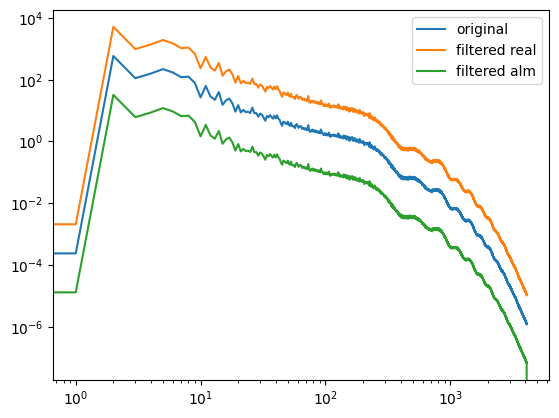

In [32]:
plt.loglog(clsoriginal, label = 'original')
plt.loglog(clreal, label = 'filtered real')
plt.loglog(clalm, label = 'filtered alm')
plt.legend()

In [39]:
slm = np.load("/Users/omard/Downloads/SCRATCHFOLDER/n32/S4WebskyWebskyBorn/lenscarfrecs/ptt_bh_s_sim0000bh/normalized_s_slm_it000.npy")

In [47]:
smap = hp.alm2map(slm, nside = nside)

In [52]:
invtotalnoise_s_alm = hp.map2alm(np.nan_to_num(invtotalnoise**-1+smap)**-1, lmax = lmax)

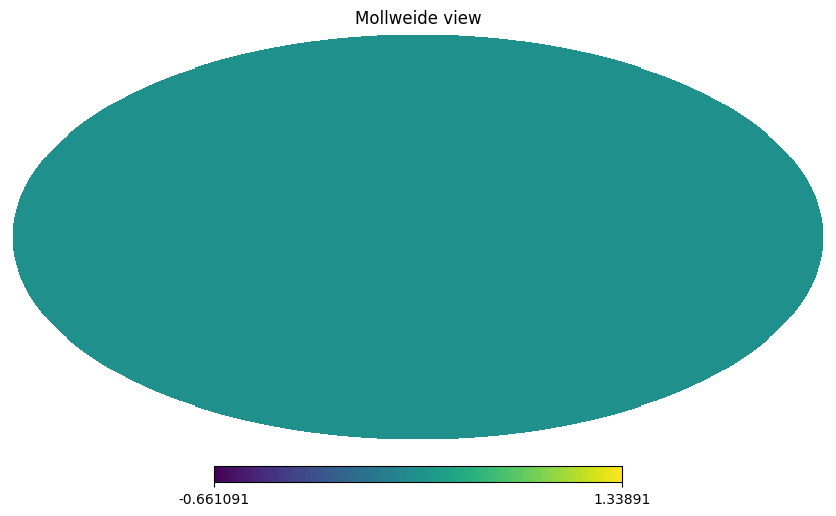

In [55]:
hp.mollview(invtotalnoise**-1.)

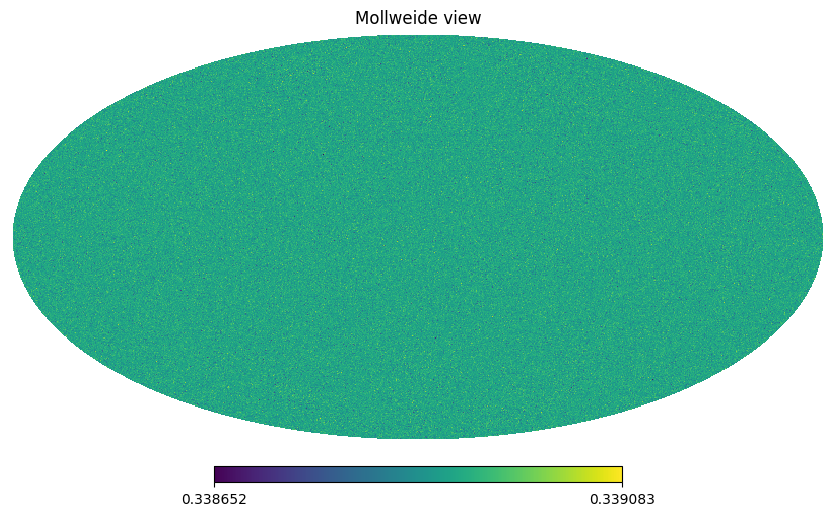

In [53]:
hp.mollview(smap+invtotalnoise**-1.)

In [ ]:
clnoise = hp.alm2cl(invtotalnoise_alm)
clnoise_s = hp.alm2cl(invtotalnoise_s_alm) 

In [41]:
cls_slm = hp.alm2cl(slm)

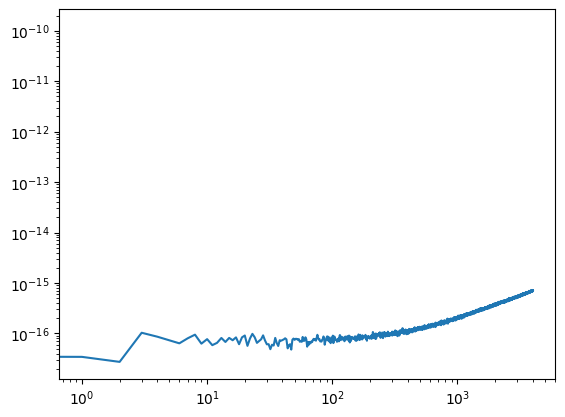

In [46]:
plt.loglog(cls_slm)

In [69]:
## generate a point sources map for healpix, with given flux
## the point sources are randomly distributed on the sky, and they are Poisson distributed
## the flux is given in Jy
## the map is generated at a given nside
## the number for point sources is given by the flux and the flux limit

##get the radio point sources popultionation using a power law for the number counts
## use formula (29) from Osborner et al 2013
def dNdS(S, N0, beta):
    return N0/S**beta

beta = 2.15
Smax = 200*1e-3 #Jy
Smin = 1e-20

N0 = 12 #Jy^{1.15}sr^{-1}

## get the number of point sources in the sky
## integrate the number counts
## use formula (30) from Osborner et al 2013
def N( Smax, Smin, N0, beta):
    return N0/(1-beta)*(Smax**(1-beta)-Smin**(1-beta))

Nsources = N(Smax, Smin, N0, beta)
Nsources


1.0434782608695609e+24

In [128]:
T0 = 2.7255

def dBdT(freq_GHz, T):
    '''d(blackbody)/dT, such that
    dI = d(blackbody)/dT * dT
    input: nu [Hz], T thermo temperature of the black body [K]
    output in SI: [W / Hz / m^2 / sr / K]
    '''
    h = 6.63e-34
    kB = 1.380658e-23
    c = 29979245800.
    nu = freq_GHz*1.e9

    x = h*nu/(kB*T)
    result = 2.*h**2*nu**4
    result /= kB*T**2*c**2
    result *= np.exp(x) / (np.exp(x) - 1.)**2

    return result

In [145]:
factor = (1.e-26) #**3.85 #from Jy to W/m^2/Hz
factor *= 1/dBdT(148, T0)
factor = factor**4

Sarray = np.linspace(1e-5, 0.2, 1000)

s4 = np.trapz(dNdS(Sarray, N0, beta)*Sarray**4., Sarray)
s4

#convert to muK^4

s4 *= factor
s4

1.7955443432160873e-20

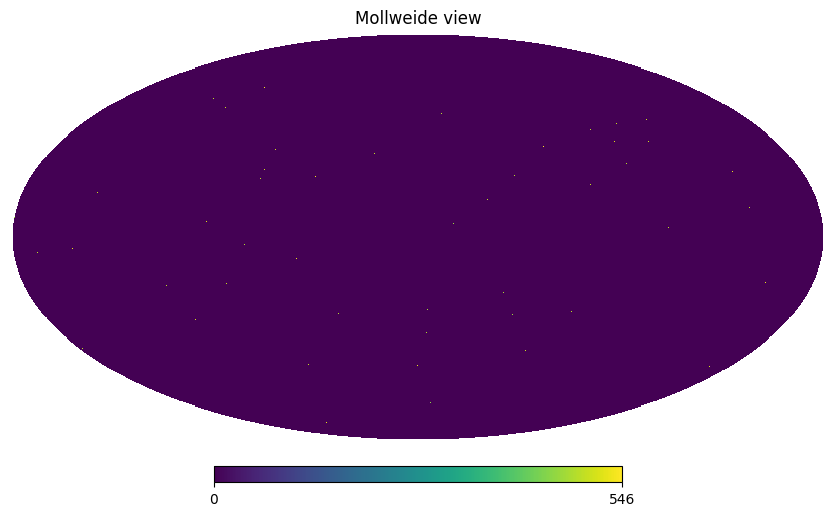

In [263]:
NN = 10000
Nsources = np.random.poisson(NN)
positions = np.random.randint(0, hp.nside2npix(nside), Nsources)
Amplitude_of_Sources = 500
amplitudes = np.random.poisson(Amplitude_of_Sources, Nsources)

mappa = np.zeros(hp.nside2npix(nside))
mappa[positions] = amplitudes

hp.mollview(mappa)

In [264]:
alm = hp.map2alm(mappa, lmax = lmax)

In [265]:
def randomizing_fg(mappa: np.ndarray):
     f = lambda z: np.abs(z) * np.exp(1j*np.random.uniform(0., 2.*np.pi, size = z.shape))
     return f(mappa)

In [266]:
almrandomized = randomizing_fg(alm)

In [294]:
hp.write_alm("almrandomizedpointsources.fits", almrandomized, overwrite = True)

In [296]:
hp.write_alm("almpointsources.fits", alm, overwrite = True)

In [267]:
!pwd

/Users/omard/Documents/projects/fgcmblensing/iterativeforegroundsfullsky/itfgs/notebooks


In [268]:
cls = hp.alm2cl(alm)

In [269]:
clsrand = hp.alm2cl(almrandomized)

In [270]:
clsrand

array([1.20290581e-05, 7.89284449e-06, 1.33934631e-05, ...,
       1.25599266e-05, 1.21456341e-05, 1.21734190e-05])

In [271]:
cls

array([1.26759519e-01, 7.93378443e-06, 1.33954649e-05, ...,
       1.25604922e-05, 1.21456345e-05, 1.21739371e-05])

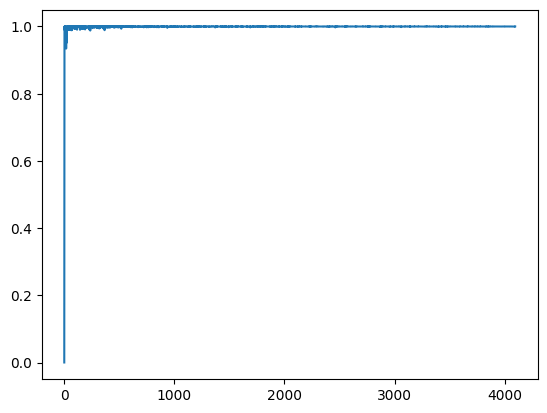

In [272]:
plt.plot(clsrand/cls)

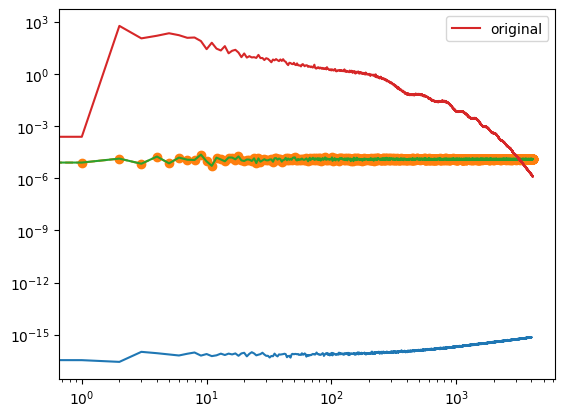

In [273]:
plt.loglog(cls_slm)
plt.loglog(clsrand, ls = '--', marker = "o")
plt.loglog(cls)
plt.loglog(clsoriginal, label = 'original')
plt.legend()

## Apply plancklens QE

In [255]:
import scipy
from scipy import signal


def bin_theory(l, cl, bin_edges):
    sums = scipy.stats.binned_statistic(l, l, statistic="sum", bins=bin_edges)
    cl = scipy.stats.binned_statistic(l, l*cl, statistic="sum", bins=bin_edges)
    cl = cl[0] / sums[0]
    return cl


bin_edges = np.arange(10, 4000, 100)

els = bin_edges[:-1] + np.diff(bin_edges)/2

In [256]:
from plancklens import utils

plmin = hp.read_alm("/Users/omard/Downloads/SCRATCHFOLDER/n32/S4WebskyWebskyBorn/cmbs/plm_in_0_lmax5120.fits")
plmin = utils.alm_copy(plmin, lmax=4500)

In [257]:
inin = hp.alm2cl(plmin)

In [289]:
directory = "/Users/omard/Downloads/SCRATCHFOLDER/n32/S4WebskyWebskyBorn/"
get_specific_dir = lambda s, k, id, v: directory+f"lenscarfrecspoint{s}/{k}_sim{id:04}{v}"
specific_name = ["NG", ""]
ks = ["ptt", "ptt_bh_s"]
vs = ["qe", "bh"]
cases = ["pointsources", "pointsourcesrand"]
ids = np.arange(4)

In [290]:
results = {}

In [291]:
for k, v in zip(ks, vs):
    temp = {}
    for case, specific in zip(cases, specific_name):
        mean = 0
        for id in ids:
            print(get_specific_dir(specific, k, id, v+case)+"/normalized_phi_plm_it000.npy")
            rec = np.load(get_specific_dir(specific, k, id, v+case)+"/normalized_phi_plm_it000.npy")
            mean += hp.alm2cl(rec, plmin)
        mean /= len(ids)
        temp[case] = mean
    results[k] = temp

/Users/omard/Downloads/SCRATCHFOLDER/n32/S4WebskyWebskyBorn/lenscarfrecspointNG/ptt_sim0000qepointsources/normalized_phi_plm_it000.npy
/Users/omard/Downloads/SCRATCHFOLDER/n32/S4WebskyWebskyBorn/lenscarfrecspointNG/ptt_sim0001qepointsources/normalized_phi_plm_it000.npy
/Users/omard/Downloads/SCRATCHFOLDER/n32/S4WebskyWebskyBorn/lenscarfrecspointNG/ptt_sim0002qepointsources/normalized_phi_plm_it000.npy
/Users/omard/Downloads/SCRATCHFOLDER/n32/S4WebskyWebskyBorn/lenscarfrecspointNG/ptt_sim0003qepointsources/normalized_phi_plm_it000.npy
/Users/omard/Downloads/SCRATCHFOLDER/n32/S4WebskyWebskyBorn/lenscarfrecspoint/ptt_sim0000qepointsourcesrand/normalized_phi_plm_it000.npy
/Users/omard/Downloads/SCRATCHFOLDER/n32/S4WebskyWebskyBorn/lenscarfrecspoint/ptt_sim0001qepointsourcesrand/normalized_phi_plm_it000.npy
/Users/omard/Downloads/SCRATCHFOLDER/n32/S4WebskyWebskyBorn/lenscarfrecspoint/ptt_sim0002qepointsourcesrand/normalized_phi_plm_it000.npy
/Users/omard/Downloads/SCRATCHFOLDER/n32/S4Websky

In [292]:
ls = np.arange(0, len(inin))

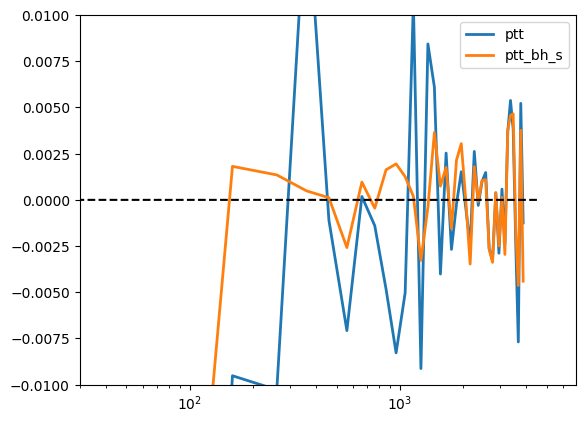

In [293]:
A, B = cases

for k, v in results.items():
    diff = v[A]-v[B] #NG-RandNG
    diff_binned = bin_theory(ls, diff, bin_edges)
    inin_binned = bin_theory(ls, inin, bin_edges)
    #p = plt.plot(diff/inin, alpha = 0.5)
    plt.plot(els, diff_binned/inin_binned, lw = "2", label = k)#, color = p[0].get_color(), label = k)
plt.plot(ls, ls*0., ls = "--", color = "k")
plt.ylim(-0.01, 0.01)
plt.xscale("log")
plt.xlim(30)
plt.legend()

In [192]:
diff/inin

/var/folders/5s/mpby42n15_ng7rv494cv19tw0000gn/T/ipykernel_41370/1274923214.py:1: RuntimeWarning: invalid value encountered in divide
  diff/inin


array([           nan, 0.00000000e+00, 1.40794146e-11, ...,
       0.00000000e+00, 3.26662121e-16, 0.00000000e+00])